In [1]:
import cv2
import numpy as n
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC
from skimage.feature import hog
import glob
import os
import time

opj = os.path.join

## Utility functions

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = n.histogram(img[:,:,0], bins=nbins)
    channel2_hist = n.histogram(img[:,:,1], bins=nbins)
    channel3_hist = n.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = n.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = n.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = n.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(n.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = n.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = n.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = n.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = n.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = n.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = n.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = n.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = n.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return n.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(n.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, return_boxes=True):
    
    draw_img = n.copy(img)
    img = img.astype(n.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (n.int(imshape[1]/scale), n.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
#     print(nxsteps, nysteps)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = n.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(n.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(n.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = n.int(xleft*scale)
                ytop_draw = n.int(ytop*scale)
                win_draw = n.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append([(xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)])
    if return_boxes:
        return draw_img, boxes
    return draw_img

def get_images(vehicle_directory, non_vehicle_directory):
    vehicles = []
    non_vehicles = []
    
    for img_dir in os.listdir(vehicle_directory):
        vehicles.extend(glob.glob(opj(vehicle_directory, img_dir, '*.png')))
        
    for img_dir in os.listdir(non_vehicle_directory):
        non_vehicles.extend(glob.glob(opj(non_vehicle_directory, img_dir, '*.png')))
    return vehicles, non_vehicles

def color_classify(vehicle_images, non_vehicle_images):
    spatial = 16
    histbin = 16

    vehicle_features = extract_features(vehicle_images, color_space='YCrCb', spatial_size=(spatial, spatial), 
                                    hist_bins=histbin, hog_channel='ALL', hog_feat=True)
    non_vehicle_features = extract_features(non_vehicle_images, color_space='YCrCb', spatial_size=(spatial, spatial),
                            hist_bins=histbin, hog_channel='ALL', hog_feat=True)

    # Create an array stack of feature vectors
    X = n.vstack((vehicle_features, non_vehicle_features)).astype(n.float64)

    # Define the labels vector
    y = n.hstack((n.ones(len(vehicle_features)), n.zeros(len(non_vehicle_features))))

    # Split up data into randomized training and test sets
    rand_state = n.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)
    print(X_train.shape)
    # Fit a per-column scaler only on the training data
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X_train and X_test
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    print('Using spatial binning of:',spatial,
        'and', histbin,'histogram bins')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    
    return svc, X_scaler

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = n.array(nonzero[0])
        nonzerox = n.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((n.min(nonzerox), n.min(nonzeroy)), (n.max(nonzerox), n.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Get training images from Udacity

In [3]:
# get images from specific path
vehicle_directory = './train_data/vehicles/'
non_vehicle_directory = './train_data/non-vehicles/'

vehicle_images, non_vehicle_images = get_images(vehicle_directory, non_vehicle_directory)

In [4]:
# helper tool to profile the benchmark
%load_ext line_profiler

## Visualize data set

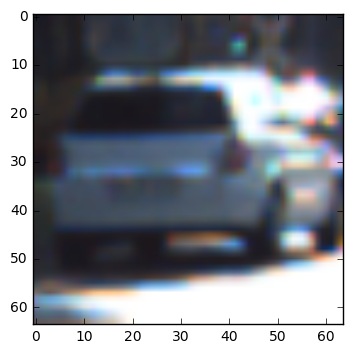

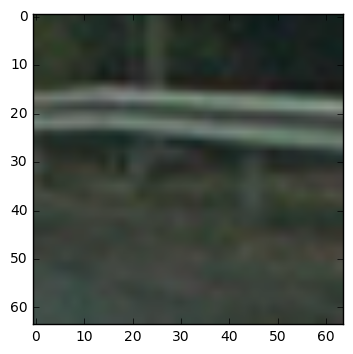

In [5]:
vehicle_test = mpimg.imread(vehicle_images[0])
plt.figure(); plt.imshow(vehicle_test)

non_vehicle_test = mpimg.imread(non_vehicle_images[1])
plt.figure(); plt.imshow(non_vehicle_test)

plt.show()

## HOG features

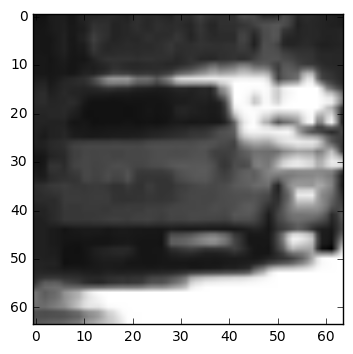

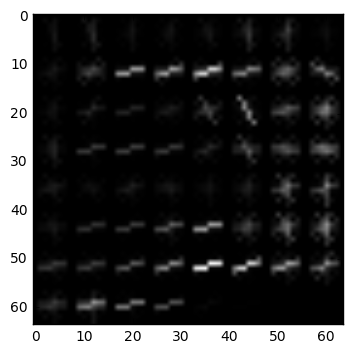

In [6]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (16, 16)
hist_bins = 16

_, hog_image = hog(vehicle_test[:,:,0], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
    cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
    visualise=True, feature_vector=True)

plt.figure(); plt.imshow(vehicle_test[:,:,0], cmap='gray')
plt.figure(); plt.imshow(hog_image, cmap='gray'); plt.show()

## Train the classifier

In [7]:
clf, X_scaler = color_classify(vehicle_images, non_vehicle_images)

(14208, 6108)
Using spatial binning of: 16 and 16 histogram bins
Feature vector length: 6108
3.0 Seconds to train SVC...
Test Accuracy of SVC =  0.9941
My SVC predicts:  [ 1.  1.  0.  1.  0.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  1.  0.  1.  0.  0.]
0.00086 Seconds to predict 10 labels with SVC


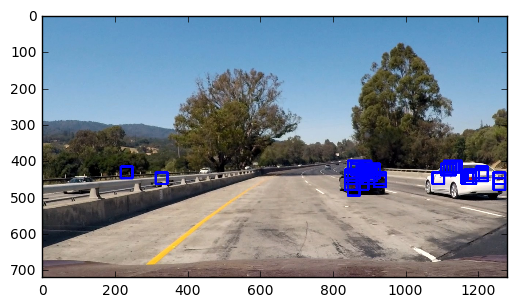

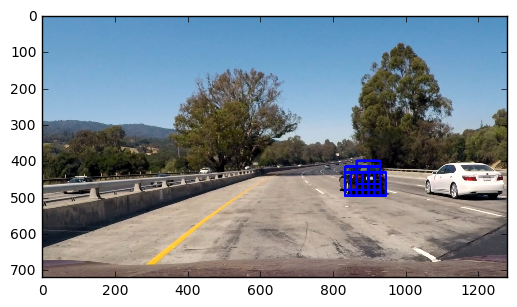

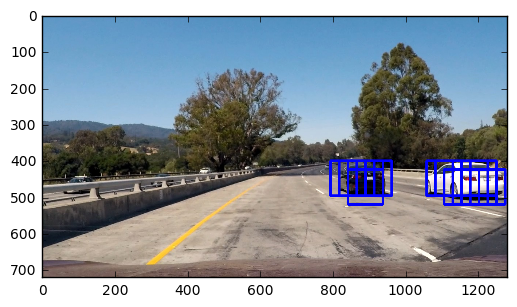

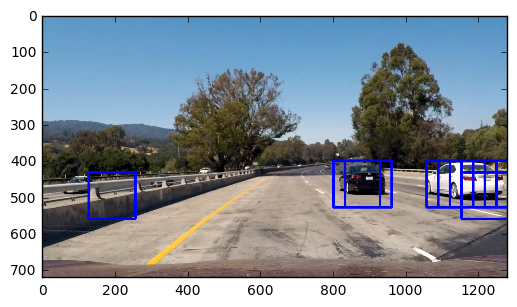

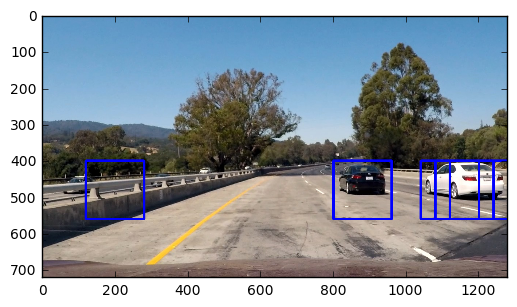

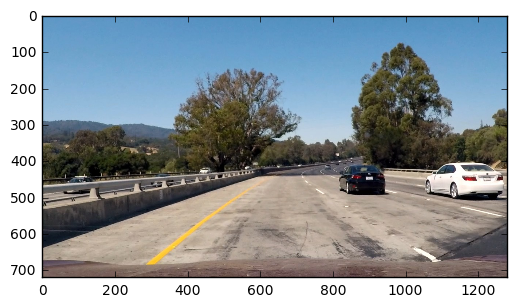

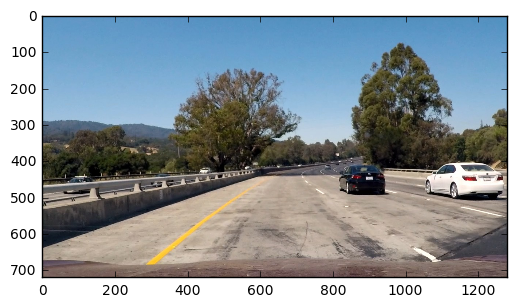

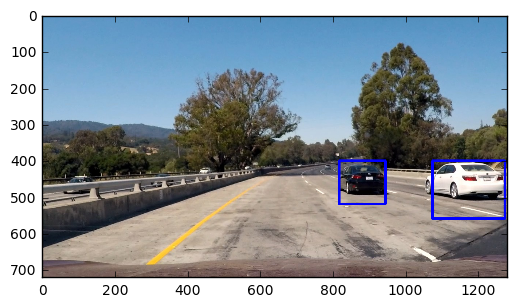

In [13]:
# parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (16, 16)
hist_bins = 16

# define the region of interest
ystart = 400
ystop = 656
scale = 2

# experiment on test images
img = mpimg.imread('./test_images/test1.jpg')

box_list = []
for scale in [0.5, 1, 1.5, 2, 2.5, 3, 4]:
    out_img, boxes = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    box_list.extend(boxes)
    plt.figure(); plt.imshow(out_img); plt.show()
    
heat = n.zeros_like(img[:,:,0]).astype(n.float)
heat = add_heat(heat, box_list)
heat = apply_threshold(heat, 3)
heatmap = n.clip(heat, 0, 255)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(n.copy(img), labels)

plt.figure(); plt.imshow(draw_img); plt.show()

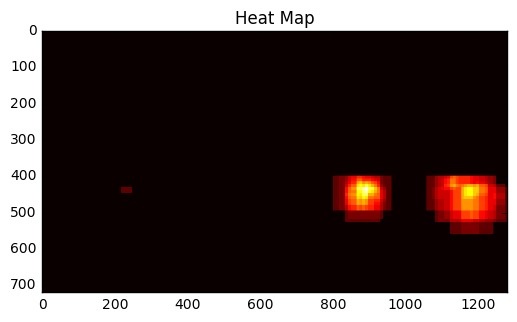

In [12]:
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.show()

In [217]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

class MyVideoProcessor(object):

    # constructor function
    def __init__(self):
        # store past frames
        self.box_list = []
        self.cur_frame = 0
        self.clf = None
        self.params = None
        
    def load_clf_n_params(self, clf, params):
        self.clf = clf
        self.params = params

    def pipeline_function(self, frame):
        box_list = []
        for scale in n.linspace(1, 4, 7):
            out_img, boxes = find_cars(frame, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
            box_list.extend(boxes)
        
        heat = n.zeros_like(frame[:,:,0]).astype(n.float)
        heat = add_heat(heat, box_list)
        heat = apply_threshold(heat, 2)
        heatmap = n.clip(heat, 0, 255)
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(n.copy(frame), labels)
        self.cur_frame += 1
        return draw_img

In [238]:
my_video_processor_object = MyVideoProcessor()

output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")

white_clip = clip.fl_image(my_video_processor_object.pipeline_function)

%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:01<39:26,  1.88s/it]

  0%|          | 2/1261 [00:03<38:46,  1.85s/it]

  0%|          | 3/1261 [00:05<38:27,  1.83s/it]

  0%|          | 4/1261 [00:07<40:21,  1.93s/it]

  0%|          | 5/1261 [00:09<41:56,  2.00s/it]

  0%|          | 6/1261 [00:11<40:33,  1.94s/it]

  1%|          | 7/1261 [00:13<39:27,  1.89s/it]

  1%|          | 8/1261 [00:15<38:56,  1.86s/it]

  1%|          | 9/1261 [00:16<38:11,  1.83s/it]

  1%|          | 10/1261 [00:18<37:18,  1.79s/it]

  1%|          | 11/1261 [00:20<36:44,  1.76s/it]

  1%|          | 12/1261 [00:22<39:11,  1.88s/it]

  1%|          | 13/1261 [00:24<40:12,  1.93s/it]

  1%|          | 14/1261 [00:26<38:58,  1.88s/it]

  1%|          | 15/1261 [00:27<38:03,  1.83s/it]

  1%|▏         | 16/1261 [00:29<38:14,  1.84s/it]

  1%|▏         | 17/1261 [00:31<37:57,  1.83s/it]

  1%|▏         | 18/1261 [00:33<37:13,  1.80s/it]

  2%|▏         | 19/1261 [00:35<36:45,  1.78s/i

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1h 47min 23s, sys: 58.8 s, total: 1h 48min 22s
Wall time: 37min 40s
